In [1]:
import xlwings as xw
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit
from sklearn.metrics import r2_score

In [2]:
# объект с рабочей excel-книгой (расположенной по заданному пути)
path_to_excel_file = os.path.join('excel_files', 'labdata_Relative permeabilities.xlsx')
wb = xw.Book(path_to_excel_file)
# имя файла с рабочей excel-книгой
wb.name

'labdata_Relative permeabilities.xlsx'

In [3]:
# листы, из которых состоит рабочая excel-книга
wb.sheets

Sheets([<Sheet [labdata_Relative permeabilities.xlsx]ОФП>])

In [4]:
# объект с первым листом excel-книги
sht = wb.sheets[0]
# имя первого листа
sht.name

'ОФП'

In [5]:
# считывает первый столбец рассматриваемого листа в список
input_data = sht.range('A1:A177').value
# вывод элементов списка
input_data[0:15]

['исходные данные',
 'Sample 1',
 None,
 'Sw',
 0.37190351403978517,
 0.42860515411379246,
 0.5079874502174027,
 0.5576013852821591,
 0.6568292554116718,
 0.722981168831347,
 0.7688149945578361,
 None,
 'Sample 2',
 None,
 'Sw']

In [6]:
# пустой список, в который будем заносить номера строк excel-листа,
# где начинаются данные нового эксперимента (Sample)
experiments_start_excel_rows = []
for i, l in enumerate(input_data):
    if isinstance(l, str) and 'Sample' in l:
        experiments_start_excel_rows.append(i + 1)
# вывод номеров строк и количества проведённых экспериментов
print(experiments_start_excel_rows)
print(f'Всего экспериментов: {len(experiments_start_excel_rows)}')

[2, 13, 24, 35, 46, 57, 68, 79, 90, 101, 112, 123, 134, 145, 156, 167]
Всего экспериментов: 16


In [7]:
# заполнение ячеек с названиями и заметками (для удобства навигации по excel-листу)
# опорными номерами, от которых отсчитываются нужные ячейки являются номера experiments_start_excel_rows
for i in experiments_start_excel_rows:
    sht.range(f'F{i+1}:H{i+1}').merge()
    sht.range(f'F{i+1}').value = 'Нормализованные ОФП'
    sht.range(f'F{i+2}:L{i+2}').value = ['Sw', 'Krw', 'Kro', 'Krw_подбор', 'Kro_подбор', 'разница Krw', 'разница Kro']

In [8]:
# считывание и нормировка данных исследований
# исходные данные в листе experiments_data, нормированные -- в листе experiments_data_norm
experiments_data = []
experiments_data_norm = []
for i in experiments_start_excel_rows:
    experiments_data.append(np.array(sht.range(f'A{i+3}:C{i+9}').value))
    sw_norm = list(
        (experiments_data[-1][:, 0] - experiments_data[-1][0, 0]) / abs(experiments_data[-1][-1, 0] - experiments_data[-1][0, 0])
    )
    krw_norm = list(
        (experiments_data[-1][:, 1] - experiments_data[-1][0, 1]) / abs(experiments_data[-1][-1, 1] - experiments_data[-1][0, 1])
    )
    kro_norm = list(
        (experiments_data[-1][:, 2] - experiments_data[-1][-1, 2]) / abs(experiments_data[-1][-1, 2] - experiments_data[-1][0, 2])
    )

    # такой трюк со списками в правой части присваивания, так как записываем в столбец excel-листа, а не в строку
    sht.range(f'F{i+3}:F{i+9}').value = [[el] for el in sw_norm]
    sht.range(f'G{i+3}:G{i+9}').value = [[el] for el in krw_norm]
    sht.range(f'H{i+3}:H{i+9}').value = [[el] for el in kro_norm]
    
    experiments_data_norm.append(np.array(sht.range(f'F{i+3}:H{i+9}').value))

In [9]:
# проверка: данные первого эксперимента после нормировки
experiments_data_norm[0]

array([[0.        , 0.        , 1.        ],
       [0.14285714, 0.31112949, 0.64945489],
       [0.34285714, 0.52609954, 0.30863659],
       [0.46785714, 0.63396891, 0.17095392],
       [0.71785714, 0.81963938, 0.02892766],
       [0.88452381, 0.9290214 , 0.00237126],
       [1.        , 1.        , 0.        ]])

In [10]:
def corey_corr(
    water_saturation: np.array,
    corey_parameters: tuple
) -> tuple:
    """
    значения ОФП воды и нефти по аппроксимации Кори для нормализованных кривых ОФП
    @param water_saturation: массив значений водонасыщенности
    @param corey_parameters: параметры аппроксимации Кори
    @return: значения ОФП воды и нефти при заданных водонасыщенностях
    """
    n_w, n_o = corey_parameters
    krw_corey = water_saturation ** n_w
    kro_corey = (1 - water_saturation) ** n_o
    return krw_corey, kro_corey

def corey_corr_error(
    corey_parameters: tuple,
    data_norm: np.array
) -> float:
    """
    ошибка корреляций Кори (с заданными параметрами) относительно экспериментальных данных
    @param corey_parameters: параметры аппроксимаций Кори
    @param data_norm: нормированные кривые ОФП (насыщенность, ОФП воды, ОФП нефти)
    @return: ошибка корреляции Кори
    """
    krw_corey, kro_corey = corey_corr(
        water_saturation = data_norm[:, 0],
        corey_parameters=corey_parameters
    ) 
    error = np.sum((krw_corey - data_norm[:, 1])**2) + np.sum((kro_corey - data_norm[:, 2])**2)
    return error

In [11]:
# проверка: подбор оптимальных параметров корреляции Кори с целью минимизации ошибки (с помощью scipy.optimize.minimize)
minimize(corey_corr_error, [1, 1], args=(experiments_data_norm[0])).x

array([0.60000153, 2.79998689])

In [12]:
# в цикле пробегаемся по всем проведённым экспериментам
# находим параметры корреляций Кори (оптимизация с целью минимизации ошибки относительно данных эксперимента)
# находим значения ОФП по корреляциям Кори и их ошибки относительно экспериментальных данных
# записываем всё в excel-лист

for i, row_in_excel in enumerate(experiments_start_excel_rows):
    n_w = round(minimize(corey_corr_error, [1, 1], args=(experiments_data_norm[i])).x[0], 3)
    n_o = round(minimize(corey_corr_error, [1, 1], args=(experiments_data_norm[i])).x[1], 3)
    sht.range(f'D{row_in_excel+1}').value = n_w
    sht.range(f'E{row_in_excel+1}').value = n_o

    krw_korey = experiments_data_norm[i][:, 0] ** n_w
    kro_korey = (1 - experiments_data_norm[i][:, 0]) ** n_o

    krw_diff = (krw_korey - experiments_data_norm[i][:, 1])**2
    kro_diff = (kro_korey - experiments_data_norm[i][:, 2])**2

    # такой трюк со списками в правой части присваивания, так как записываем в столбец excel-листа, а не в строку
    sht.range(f'I{row_in_excel+3}:I{row_in_excel+9}').value = [[el] for el in krw_korey]
    sht.range(f'J{row_in_excel+3}:J{row_in_excel+9}').value = [[el] for el in kro_korey]
    sht.range(f'K{row_in_excel+3}:K{row_in_excel+9}').value = [[el] for el in krw_diff]
    sht.range(f'L{row_in_excel+3}:L{row_in_excel+9}').value = [[el] for el in kro_diff]

    # записываем в excel-лист сумму ошибок ОФП воды и нефти для данного эксперимента
    sht.range(f'K{row_in_excel+10}').value = np.sum(sht.range(f'K{row_in_excel+3}:K{row_in_excel+9}').value)
    sht.range(f'L{row_in_excel+10}').value = np.sum(sht.range(f'L{row_in_excel+3}:L{row_in_excel+9}').value)


In [13]:
# объединение важных данных по всем экспериментам, имеющимся на листе, 
# и их запись на этом же листе справа (для наглядности и удобства)

poro = []  # значения пористостей
perm = []  # значения проницаемостей
swcr = []  # значения критических водонасыщенностей
sowcr = []  # значения нефтенасыщенностей при максимальной водонасыщенности
krwr = []  # ОФП воды при максимальной водонасыщенности
krorw = []  # ОФП нефти при критической водонасыщенности
n_w = []  # параметр Кори для воды
n_o = []  # параметр Кори для нефти

# добавление данных в цикле
for i, d in enumerate(experiments_start_excel_rows):
    poro.append(sht.range(f'B{d+1}').value)
    perm.append(sht.range(f'C{d+1}').value)
    swcr.append(sht.range(f'A{d+3}').value)
    sowcr.append(1 - sht.range(f'A{d+9}').value)
    krwr.append(sht.range(f'B{d+9}').value)
    krorw.append(sht.range(f'C{d+3}').value)
    n_w.append(sht.range(f'D{d+1}').value)
    n_o.append(sht.range(f'E{d+1}').value)

# объединение и запись данных в excel-лист
summary = list(zip(poro, perm, swcr, sowcr, krwr, krorw, n_w, n_o))
sht.range('Z3:AG18').value = summary

# запись средних значений в столбцах (названия столбцов представлены в списке в цикле)
for s in ['AE', 'AF', 'AG']:
    sht.range(s+'19').value = np.mean(sht.range(s+'3:'+s+'18').value)

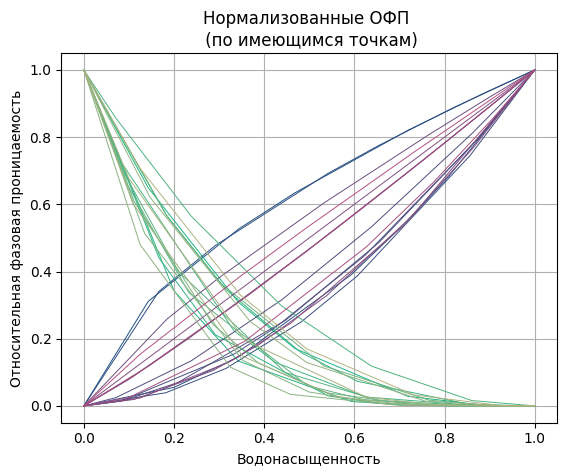

In [14]:
# построение кривых ОФП по имеющимся точкам
plt.figure()
for i, experiment in enumerate(experiments_data_norm):
    plt.plot(experiment[:, 0], experiment[:, 1], color=(0.1+i/25, 0.3, 0.5), linewidth=0.7)
    plt.plot(experiment[:, 0], experiment[:, 2], color=(0.1+i/25, 0.7, 0.5), linewidth=0.7)
plt.title('Нормализованные ОФП \n (по имеющимся точкам)')
plt.xlabel('Водонасыщенность')
plt.ylabel('Относительная фазовая проницаемость')
plt.grid()

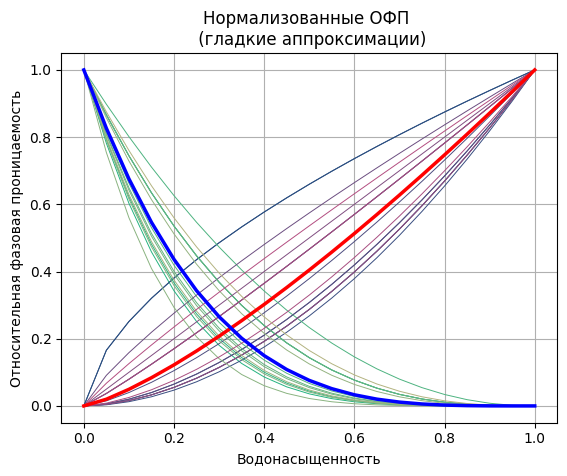

In [15]:
# построение кривых ОФП по наиболее близким гладким аппроксимациям Кори
plt.figure()
for i, experiment in enumerate(experiments_data_norm):
    plt.plot(
        np.arange(0, 1.01, 0.05),
        corey_corr(np.arange(0, 1.01, 0.05), (n_w[i], n_o[i]))[0],
        color=(0.1+i/25, 0.3, 0.5),
        linewidth=0.7
    )
    plt.plot(
        np.arange(0, 1.01, 0.05),
        corey_corr(np.arange(0, 1.01, 0.05), (n_w[i], n_o[i]))[1],
        color=(0.1+i/25, 0.7, 0.5),
        linewidth=0.7
    )


# построение средних кривых ОФП
plt.plot(
    np.arange(0, 1.01, 0.05),
    corey_corr(np.arange(0, 1.01, 0.05), (np.mean(n_w), np.mean(n_o)))[0],
    color=(1, 0, 0),
    linewidth=2.5
)

plt.plot(
    np.arange(0, 1.01, 0.05),
    corey_corr(np.arange(0, 1.01, 0.05), (np.mean(n_w), np.mean(n_o)))[1],
    color=(0, 0, 1),
    linewidth=2.5
)

plt.title('Нормализованные ОФП \n (гладкие аппроксимации)')
plt.xlabel('Водонасыщенность')
plt.ylabel('Относительная фазовая проницаемость')
plt.grid()

In [16]:
# сохраниение изменений в редактируемом excel-файле
wb.save(os.path.join('excel_files', 'labdata_Relative permeabilities.xlsx'))

Text(0, 0.5, 'krorw')

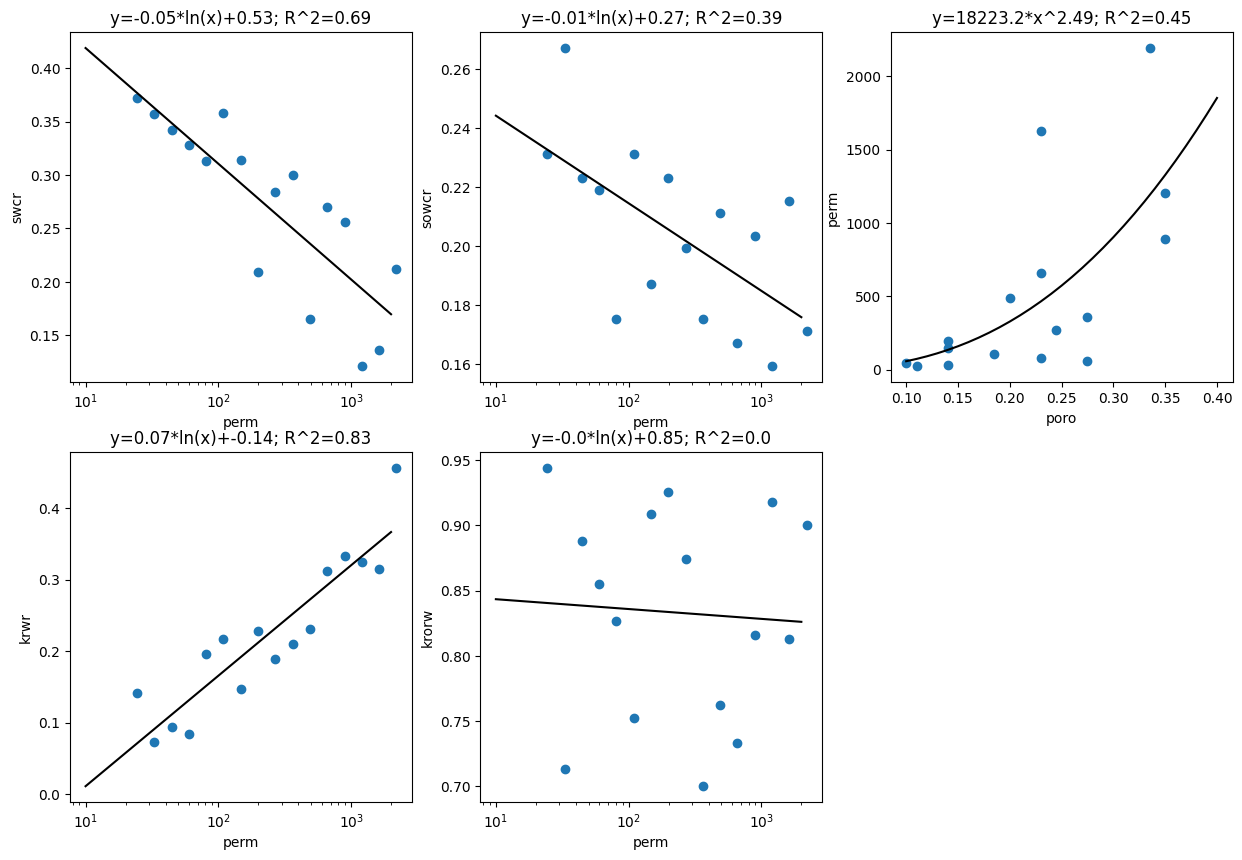

In [17]:
plt.figure(figsize=(15,10))


# корреляция swcr и perm
plt.subplot(2, 3, 1)
ax = plt.gca()
plt.scatter(perm, swcr)
ax.set_xscale('log')

def func1(x, a, b):
    y = a * np.log(x) + b
    return y

popt, pcov = curve_fit(func1, xdata=perm, ydata=swcr)
swcr_pred = func1(perm, *popt)
plt.plot(np.arange(10, 2000, 1), func1(np.arange(10, 2000, 1), *popt), color='black')
plt.title(f'y={round(popt[0],2)}*ln(x)+{round(popt[1],2)}; R^2={round(r2_score(swcr, swcr_pred), 2)}')
plt.xlabel('perm')
plt.ylabel('swcr')


# корреляция sowcr и perm
plt.subplot(2, 3, 2)
ax = plt.gca()
plt.scatter(perm, sowcr)
ax.set_xscale('log')

def func2(x, a, b):
    y = a * np.log(x) + b
    return y

popt, pcov = curve_fit(func2, xdata=perm, ydata=sowcr)
sowcr_pred = func2(perm, *popt)
plt.plot(np.arange(10, 2000, 1), func2(np.arange(10, 2000, 1), *popt), color='black')
plt.title(f'y={round(popt[0],2)}*ln(x)+{round(popt[1],2)}; R^2={round(r2_score(sowcr, sowcr_pred), 2)}')
plt.xlabel('perm')
plt.ylabel('sowcr')


# корреляция perm и poro
plt.subplot(2, 3, 3)
plt.scatter(poro, perm)

def func3(x, a, b):
    y = a * x ** b
    return y

popt, pcov = curve_fit(func3, xdata=poro, ydata=perm)
perm_pred = func3(poro, *popt)
plt.plot(np.arange(0.1, 0.4, 0.01), func3(np.arange(0.1, 0.4, 0.01), *popt), color='black')
plt.title(f'y={round(popt[0],2)}*x^{round(popt[1],2)}; R^2={round(r2_score(perm, perm_pred), 2)}')
plt.xlabel('poro')
plt.ylabel('perm')


# корреляция krwr и perm
plt.subplot(2, 3, 4)
ax = plt.gca()
plt.scatter(perm, krwr)
ax.set_xscale('log')

def func4(x, a, b):
    y = a * np.log(x) + b
    return y

popt, pcov = curve_fit(func4, xdata=perm, ydata=krwr)
krwr_pred = func4(perm, *popt)
plt.plot(np.arange(10, 2000, 1), func4(np.arange(10, 2000, 1), *popt), color='black')
plt.title(f'y={round(popt[0],2)}*ln(x)+{round(popt[1],2)}; R^2={round(r2_score(krwr, krwr_pred), 2)}')
plt.xlabel('perm')
plt.ylabel('krwr')


# корреляция krorw и perm
plt.subplot(2, 3, 5)
ax = plt.gca()
plt.scatter(perm, krorw)
ax.set_xscale('log')

def func5(x, a, b):
    y = a * np.log(x) + b
    return y

popt, pcov = curve_fit(func5, xdata=perm, ydata=krorw)
krorw_pred = func5(perm, *popt)
plt.plot(np.arange(10, 2000, 1), func5(np.arange(10, 2000, 1), *popt), color='black')
plt.title(f'y={round(popt[0],2)}*ln(x)+{round(popt[1],2)}; R^2={round(r2_score(krorw, krorw_pred), 2)}')
plt.xlabel('perm')
plt.ylabel('krorw')
